# Основная часть

In [4]:
import pandas as pd
from google.colab import drive
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
pd.set_option('display.max_rows', None)       # Показывать все строки
pd.set_option('display.max_columns', None)    # Показывать все столбцы
pd.set_option('display.width', None)          # Не ограничивать ширину вывода
pd.set_option('display.max_colwidth', None)

In [6]:
drive.mount('/content/drive')
link = '/content/drive/MyDrive/Ферматисты/df_for_sirius_clean.csv'
#link = 'https://drive.google.com/file/d/1LayOqDaYsLZ458KNzFHb-LDFA0A8g7Y2/view?usp=drive_link'
df = pd.read_csv(link, sep=',')

Mounted at /content/drive


# Разделение по кластерам

In [7]:
# Из очищенного датасета выделим кластеры (получим очищенные кластеры)

def separate_cluster(num):
  link = '/content/drive/MyDrive/Ферматисты/cluster_' + str(num) +'.csv'
  pk_cluster_num = pd.read_csv(link, sep=';')[['expiration_minus_1d_dt', 'id', 'target', 'months_cnt']]

  df_cluster_num = df.merge(
    pk_cluster_num,
    on=['expiration_minus_1d_dt', 'id', 'target', 'months_cnt'],
    how='inner'
  )
  return df_cluster_num

df_cluster_0 = separate_cluster(0)
df_cluster_1 = separate_cluster(1)
df_cluster_2 = separate_cluster(2)

In [8]:
# def write_df_cluster_to_csv(df_cluster_num, num):

#   folder_path = '/content/drive/MyDrive/Ферматисты/'

#   file_path = os.path.join(folder_path, 'cluster_' + str(num) + '_clean.csv')

#   df_cluster_num.to_csv(file_path, index=False, encoding='utf-8-sig')

In [9]:
# write_df_cluster_to_csv(df_cluster_0, 0)
# write_df_cluster_to_csv(df_cluster_1, 1)
# write_df_cluster_to_csv(df_cluster_2, 2)

In [10]:
df_by_date_general = df.groupby(by='expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
df_by_date_general = df_by_date_general.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})

In [11]:
df_by_date_general['date'] = pd.to_datetime(df_by_date_general['date'], format='%Y-%m-%d')

In [12]:
# Создаем датафреймы для каждого кластера по дням с кол-вом выведенных вкладов (target=1)

def make_df_by_date_cluster(df_cluster_num):
  df_by_date = df_cluster_num.groupby(by='expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
  df_by_date = df_by_date.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})

  return df_by_date

In [13]:
df_by_date_cluster_0 = make_df_by_date_cluster(df_cluster_0)
df_by_date_cluster_1 = make_df_by_date_cluster(df_cluster_1)
df_by_date_cluster_2 = make_df_by_date_cluster(df_cluster_2)

In [14]:
df_by_date_cluster_0.head()

,date,target_1_cnt
0,2024-01-01,252
1,2024-01-02,185
2,2024-01-03,198
3,2024-01-04,159
4,2024-01-05,136


# Смотим отток (target=1) по кластерам

In [15]:
def create_target_column_cluster_num(df_by_date):

  target_column = df_by_date[['date', 'target_1_cnt']]
  target_column['date'] = pd.to_datetime(target_column['date'], format='%Y-%m-%d')
  return target_column

In [16]:
target_column_cluster_0 = create_target_column_cluster_num(df_by_date_cluster_0)
target_column_cluster_1 = create_target_column_cluster_num(df_by_date_cluster_1)
target_column_cluster_2 = create_target_column_cluster_num(df_by_date_cluster_2)

In [17]:
# Рисуем графики кол-ва выведенных вкладов по каждому кластеру

def make_lineplot_target_1_by_date(df_by_date, num):
  df_by_date['date'] = pd.to_datetime(df_by_date['date'])
  df_by_date = df_by_date.sort_values('date')

  # Создаем график
  fig = px.line(
      df_by_date,
      x='date',
      y='target_1_cnt',
      title='Ежедневное количество закрытий счетов (target=1) клиентов кластера ' + str(num),
      labels={'date': 'Дата', 'target_count': 'Количество закрытий'},
      width=1200,
      height=600
  )

  # Настраиваем отображение дат на оси X (группировка по месяцам)
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y",
      ticklabelmode="period",
      showgrid=True
  )

  fig.update_layout(
      xaxis=dict(
          showspikes=True,
          spikemode='across',
          spikesnap='cursor',
          spikedash='solid',
          spikecolor='grey',
          spikethickness=1
      ),
      hovermode='x unified'
  )

  # Настраиваем отображение при наведении
  fig.update_traces(
      hovertemplate=(
          '<b>Дата:</b> %{x|%d %b %Y}<br>'
          '<b>Закрытий:</b> %{y}<extra></extra>'
      ),
      line=dict(width=2.5)
  )

  fig.show()

In [18]:
make_lineplot_target_1_by_date(df_by_date_cluster_0, 0)

In [19]:
make_lineplot_target_1_by_date(df_by_date_cluster_1, 1)

In [20]:
make_lineplot_target_1_by_date(df_by_date_cluster_2, 2)

In [21]:
link = '/content/drive/MyDrive/Ферматисты/outside_factors.csv'
df_outside_factors = pd.read_csv(link, sep=',')
df_outside_factors['date'] = pd.to_datetime(df_outside_factors['date'], format='%Y-%m-%d')
df_outside_factors.head()

,date,dollar_price,mortgage_rate,moex_price,keyrate,inflation,yield,snp500_price,gold_price,btc_price
0,2024-01-01,89.5,7.91,NaN,16.0,7.44,4.18,NaN,NaN,43224.0
1,2024-01-02,89.3,7.91,NaN,16.0,7.44,4.18,4744.02,2063.95,44573.0
2,2024-01-03,89.1,7.91,3115.005,16.0,7.44,4.18,4714.94,2034.20,43905.0
3,2024-01-04,88.9,7.91,3138.365,16.0,7.44,4.19,4693.05,2041.95,43518.0
4,2024-01-05,88.7,7.91,3137.320,16.0,7.44,4.21,4693.91,2043.45,44178.0


# Внешние признаки по кластерам + корреляции

In [22]:
# Создаем внешние признаки для каждого кластера
# Мерджим таблицу с внешними признаками на кол-во target=1 для каждого кластера

def create_df_outside_factors_cluster_num (target_column, df_outside_factors):

  df_outside_factors_target_cluster_num = df_outside_factors.merge(target_column, how='inner', on='date')
  return df_outside_factors_target_cluster_num

In [23]:
df_outside_factors_target_cluster_0 = create_df_outside_factors_cluster_num (target_column_cluster_0, df_outside_factors)
df_outside_factors_target_cluster_1 = create_df_outside_factors_cluster_num (target_column_cluster_1, df_outside_factors)
df_outside_factors_target_cluster_2 = create_df_outside_factors_cluster_num (target_column_cluster_2, df_outside_factors)

In [24]:
df_outside_factors_target_cluster_0.head()

,date,dollar_price,mortgage_rate,moex_price,keyrate,inflation,yield,snp500_price,gold_price,btc_price,target_1_cnt
0,2024-01-01,89.5,7.91,NaN,16.0,7.44,4.18,NaN,NaN,43224.0,252
1,2024-01-02,89.3,7.91,NaN,16.0,7.44,4.18,4744.02,2063.95,44573.0,185
2,2024-01-03,89.1,7.91,3115.005,16.0,7.44,4.18,4714.94,2034.20,43905.0,198
3,2024-01-04,88.9,7.91,3138.365,16.0,7.44,4.19,4693.05,2041.95,43518.0,159
4,2024-01-05,88.7,7.91,3137.320,16.0,7.44,4.21,4693.91,2043.45,44178.0,136


In [25]:
# Считаем корреляции Спирмана внешних признаков и целевой target

def count_correlations_spearman_outside_factors(df_outside_factors, num):

  corr_matrix = df_outside_factors[['dollar_price', 'mortgage_rate', 'moex_price', 'keyrate', 'gold_price', 'inflation', 'yield', 'snp500_price', 'btc_price', 'target_1_cnt']].corr(method='spearman')

  target_corr = corr_matrix[['target_1_cnt']].drop('target_1_cnt')

  plt.figure(figsize=(8, 6))
  sns.heatmap(target_corr.sort_values('target_1_cnt', ascending=False),
              annot=True,
              cmap='coolwarm',
              center=0,
              vmin=-1, vmax=1,
              fmt=".2f",
              linewidths=.5,
              cbar_kws={'label': 'Коэффициент корреляции Спирмена'})

  plt.title('Корреляция внешних факторов с количеством закрытий счетов кластер ' + str(num))
  plt.tight_layout()
  plt.show()

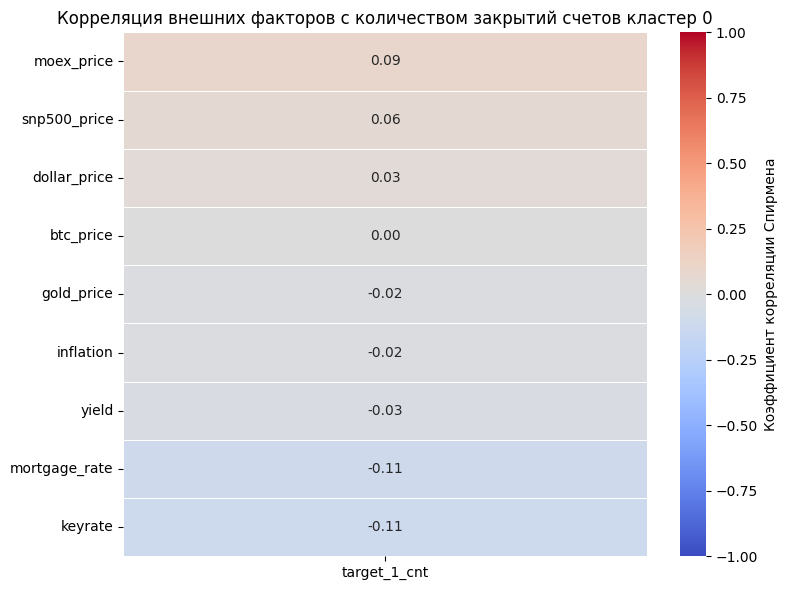

In [26]:
count_correlations_spearman_outside_factors(df_outside_factors_target_cluster_0, 0)

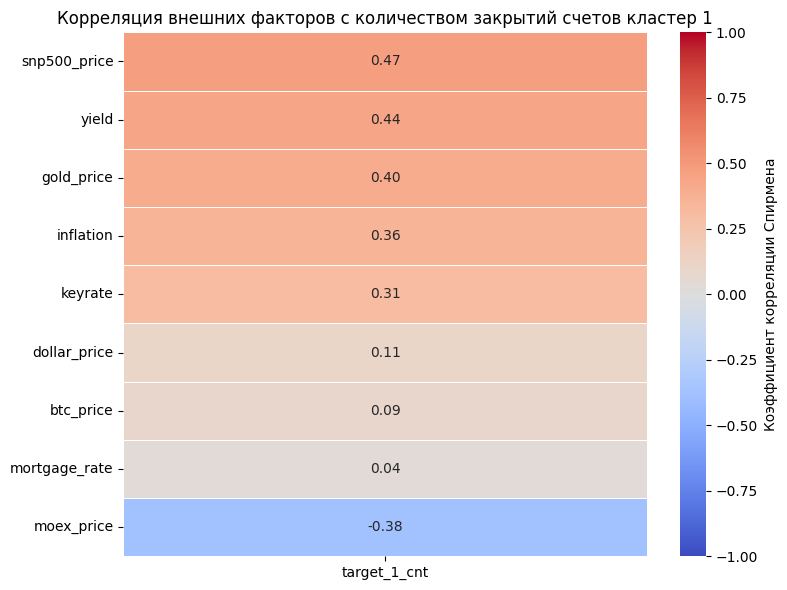

In [27]:
count_correlations_spearman_outside_factors(df_outside_factors_target_cluster_1, 1)

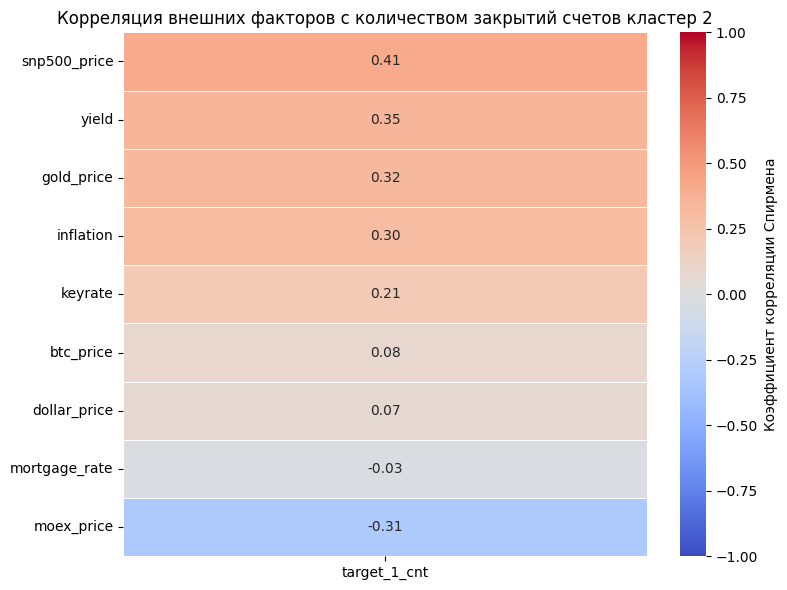

In [28]:
count_correlations_spearman_outside_factors(df_outside_factors_target_cluster_2, 2)

In [29]:
# Считаем корреляции внешних признаков и целевой target

def count_correlations_pearson_outside_factors(df_outside_factors, num):

  corr_matrix = df_outside_factors[['dollar_price', 'mortgage_rate', 'moex_price', 'keyrate', 'gold_price', 'inflation', 'yield', 'snp500_price', 'btc_price', 'target_1_cnt']].corr(method='pearson')

  target_corr = corr_matrix[['target_1_cnt']].drop('target_1_cnt')

  plt.figure(figsize=(8, 6))
  sns.heatmap(target_corr.sort_values('target_1_cnt', ascending=False),
              annot=True,
              cmap='coolwarm',
              center=0,
              vmin=-1, vmax=1,
              fmt=".2f",
              linewidths=.5,
              cbar_kws={'label': 'Коэффициент корреляции Пирсона'})

  plt.title('Корреляция внешних факторов с количеством закрытий счетов кластер ' + str(num))
  plt.tight_layout()
  plt.show()

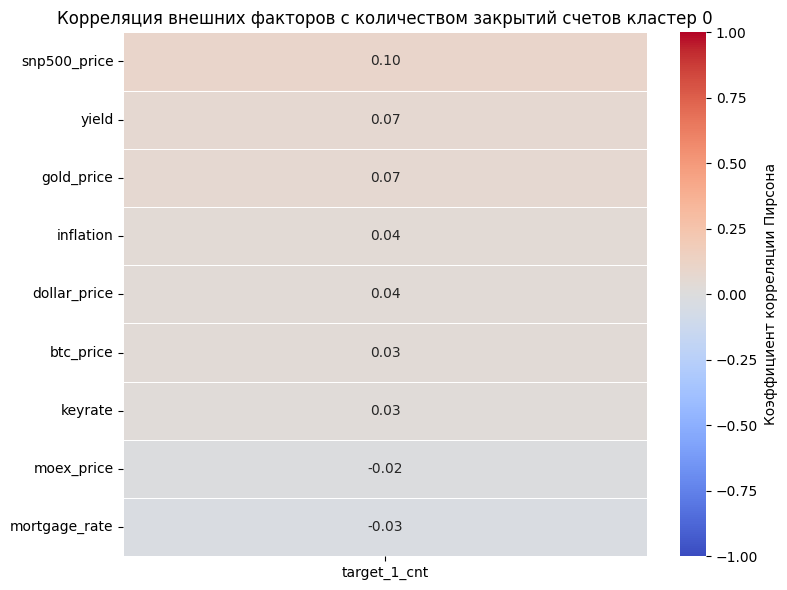

In [30]:
count_correlations_pearson_outside_factors(df_outside_factors_target_cluster_0, 0)

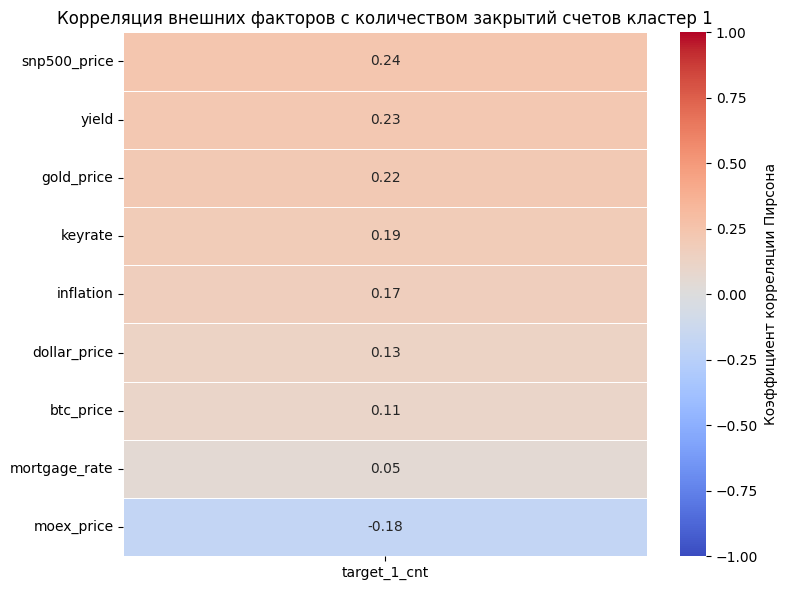

In [31]:
count_correlations_pearson_outside_factors(df_outside_factors_target_cluster_1, 1)

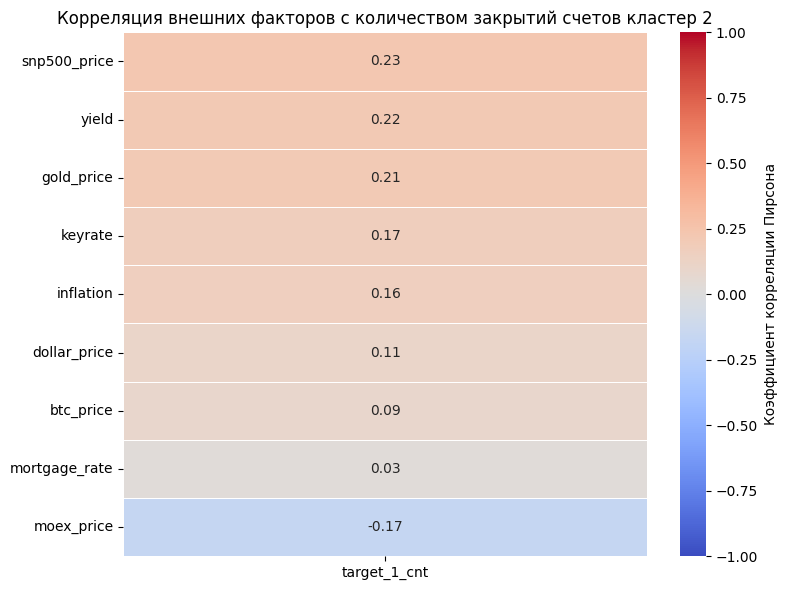

In [32]:
count_correlations_pearson_outside_factors(df_outside_factors_target_cluster_2, 2)

In [33]:
df_outside_factors_target = df_outside_factors.merge(df_by_date_general, how='inner', on='date')

In [34]:
df_outside_factors_target.head()

,date,dollar_price,mortgage_rate,moex_price,keyrate,inflation,yield,snp500_price,gold_price,btc_price,target_1_cnt
0,2024-01-01,89.5,7.91,NaN,16.0,7.44,4.18,NaN,NaN,43224.0,248
1,2024-01-02,89.3,7.91,NaN,16.0,7.44,4.18,4744.02,2063.95,44573.0,223
2,2024-01-03,89.1,7.91,3115.005,16.0,7.44,4.18,4714.94,2034.20,43905.0,217
3,2024-01-04,88.9,7.91,3138.365,16.0,7.44,4.19,4693.05,2041.95,43518.0,171
4,2024-01-05,88.7,7.91,3137.320,16.0,7.44,4.21,4693.91,2043.45,44178.0,155


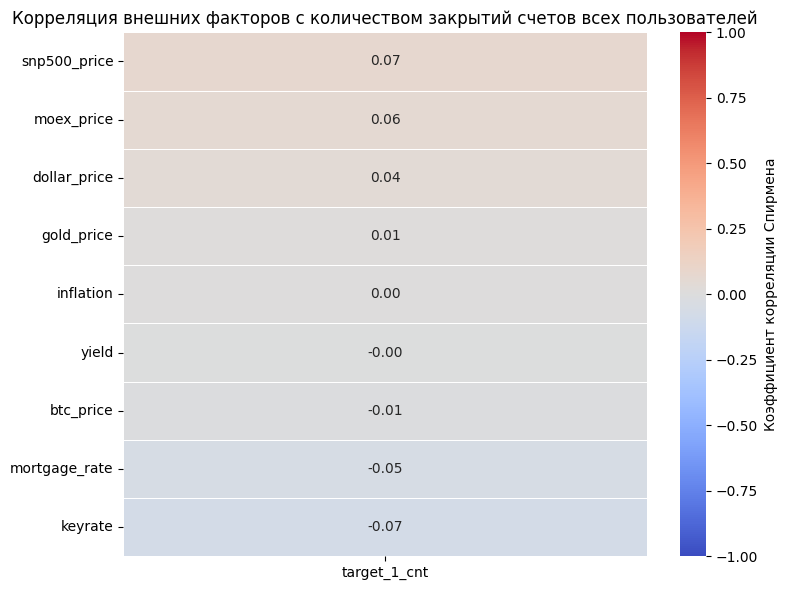

In [35]:
# Смотрим корреляцию для всех клинетов (не по кластерам)

corr_matrix = df_outside_factors_target[['dollar_price', 'mortgage_rate', 'moex_price', 'keyrate', 'gold_price', 'inflation', 'yield', 'snp500_price', 'btc_price', 'target_1_cnt']].corr(method='spearman')

target_corr = corr_matrix[['target_1_cnt']].drop('target_1_cnt')

plt.figure(figsize=(8, 6))
sns.heatmap(target_corr.sort_values('target_1_cnt', ascending=False),
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            fmt=".2f",
            linewidths=.5,
            cbar_kws={'label': 'Коэффициент корреляции Спирмена'})

plt.title('Корреляция внешних факторов с количеством закрытий счетов всех пользователей')
plt.tight_layout()
plt.show()

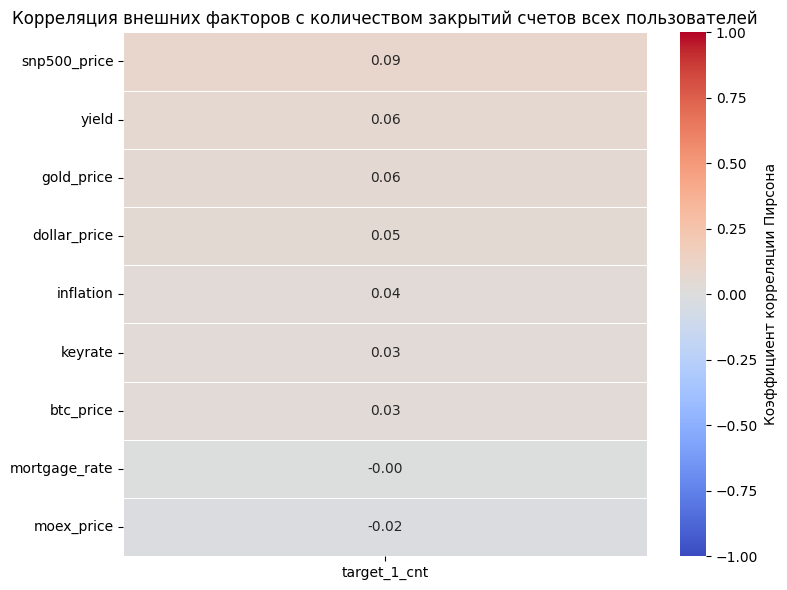

In [36]:
# Смотрим корреляцию для всех клинетов (не по кластерам)

corr_matrix = df_outside_factors_target[['dollar_price', 'mortgage_rate', 'moex_price', 'keyrate', 'gold_price', 'inflation', 'yield', 'snp500_price', 'btc_price', 'target_1_cnt']].corr(method='pearson')

target_corr = corr_matrix[['target_1_cnt']].drop('target_1_cnt')

plt.figure(figsize=(8, 6))
sns.heatmap(target_corr.sort_values('target_1_cnt', ascending=False),
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            fmt=".2f",
            linewidths=.5,
            cbar_kws={'label': 'Коэффициент корреляции Пирсона'})

plt.title('Корреляция внешних факторов с количеством закрытий счетов всех пользователей')
plt.tight_layout()
plt.show()

# Раздельно посмотрим отток по срокам вкладов (не по кластерам, а в общем датафрейме)

In [37]:
# df['month_cnt'].value_counts()
df.head()

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,avg_out_puc,credit_amt_norm_cls_max,months_cnt,renewal_cnt,high_category_loyalty_accrual_rub_amt,high_category_loyalty_accrual_bns_amt,3+_aktivnyh_produkta,Deneg_bolee_100tys,Deneg_bolee_10tys,Traty_bolee_10tys,IFL,Strahovanie_ipoteki,Oteli,Kasko,Karshering,VZR,Sovmestnyj_schet,Vklad,IIS,Travel,Oplatil_toplivo_v_Tinkoff_Gorod,Sharing_scheta,Oplatil_shtraf,Avtoplatezh,LifeStyle,Kubyshka,Popolnjal_brokerskij,Dopka_na_3_litso,Biznes_schet,Osago,Poluchaet_ZP,Privel_druga,used_special_offer,ZhKH,Poluchil_mezhbankovskij_perevod,Podpiski_na_servisy,Junior,Est'_mobajl,Investkopilka,Nakopitel'nyj_schet,Taksi,NS_keptivnaja_strahovka,Popolnil_v_bankomate,Zapravki,Podpiska_na_shtrafy,Brokerskij_schet,Perevod_po_telefonu_karte_so_sbera,Dostavka_edy,Odezhda_elektronika,Oplata_SBP_po_QR,Ecom,Obschestvennyj_transport,Internet,Mobil'naja_svjaz',Kafe_restorany_fastfud,Onlajn_tranzaktsija,Kreditnyj_produkt,Ishodjaschij_SBP_perevod,Supermarket,Poluchil_vhodjaschij_SBP,Est'_DK,party_rk_count,Mobajl_kontaktnyj_nomer,count_top_friends,max_count_of_close_mob,time_since_utilization_brk,time_since_opened_mob,full_time_mob,count_of_utils_mob,count_of_open_brk,count_of_ever_opened_tcn,count_of_ever_opened_ccr,count_of_all_open,age,min_age,use_sum_month_12_cnt,use_union_month_cnt,delay_m4_cnt,accnt_auto_cnt,zkr_open_accnt_cnt,days_cred_use_sum,accnt_rev_cnt,accnt_cnt,max_out_tel_mbk_cnt,max_out_puc_cnt,max_days_from_open_dt_min,out_request_cnt_sum,out_request_cnt_3,out_request_cnt_3_sum,out_request_cnt,median_friend_lifetime,median_count_of_ever_opened_cor,median_turnover,mpl_std_time,education_level_cd,marital_status_cd,risk_level_cd,authorization_type_cd,time_zone_delta_tm,gender_cd,days_from_bki_request_dt_max,days_from_open_dt_max,days_from_open_dt_min,avg_friend_lifetime,avg_count_of_utils_lon,stddev_total_curr_balance,avg_in_c2c_int_amt,avg_in_sbp_cnt,avg_purchase_interchange_fee_amt,avg_total_cur_balance,avg_turnover,avg_out_request_cnt_3,avg_credit_amt_opn_rev_sum,avg_out_request_cnt,avg_delay_m4_cnt,avg_credit_amt_norm_cls_max,avg_hl_delay_log,longitude,avg_education_level,gender_rate,ipl_perc,ratio_outstnd_credit_rev,cur_delqbalance_max,log_p_q_av,zkr_debt_sum,cred_av_log,hl_delay_log,credit_amt_opn_rev_sum,outstnd_amt_opn_nrev_sum,outst_rate,wrst_delqbalance_max,diff_sovkombank_24_max,diff_sovkombank_12_max,diff_sovkombank_6_max,diff_sovkombank_3_max,diff_sber_24_max,diff_sber_12_max,diff_sber_6_max,diff_sber_3_max,diff_sber_2_max,diff_russkiy_standart_24_max,diff_russkiy_standart_12_max,diff_russkiy_standart_6_max,diff_russkiy_standart_3_max,diff_rosselkhoz_24_max,diff_rosselkhoz_12_max,diff_rosselkhoz_6_max,diff_rosselkhoz_3_max,diff_rayffayzen_24_max,diff_rayffayzen_12_max,diff_rayffayzen_6_max,diff_rayffayzen_3_max,diff_promsvyazbank_24_max,diff_promsvyazbank_12_max,diff_promsvyazbank_6_max,diff_promsvyazbank_3_max,diff_psb_24_max,diff_psb_12_max,diff_psb_6_max,diff_psb_3_max,diff_mkb_24_max,diff_mkb_12_max,diff_mkb_6_max,diff_mkb_3_max,diff_mkb_2_max,diff_gazprombank_24_max,diff_gazprombank_12_max,diff_gazprombank_6_max,diff_gazprombank_3_max,diff_vtb_24_max,diff_vtb_12_max,diff_vtb_6_max,diff_vtb_3_max,diff_alfa_bank_24_max,diff_alfa_bank_12_max,diff_alfa_bank_6_max,diff_alfa_bank_3_max,diff_sovkombank_24_mean,diff_sovkombank_12_mean,diff_sovkombank_6_mean,diff_sovkombank_3_mean,diff_sber_24_mean,diff_sber_12_mean,diff_sber_6_mean,diff_sber_3_mean,diff_sber_2_mean,diff_russkiy_standart_24_mean,diff_russkiy_standart_12_mean,diff_russkiy_standart_6_mean,diff_russkiy_standart_3_mean,diff_rosselkhoz_24_mean,diff_rosselkhoz_12_mean,diff_rosselkhoz_6_mean,diff_rosselkhoz_3_mean,diff_rayffayzen_24_mean,diff_rayffayzen_12_mean,diff_rayffayzen_6_mean,diff_rayffayzen_3_mean,diff_promsvyazbank_24_mean,diff_promsvyazbank_12_mean,diff_promsvyazbank_6_mean,diff_promsvy

Аггрегируем каждый из дф с разными сроками вкладов по дням (найдем суммарный отток по дням)

In [38]:
# df.head()
df['months_cnt'].value_counts()

,count
months_cnt,
3,233974
2,183408
6,88472
4,48652
12,24754
5,8599
11,1458
18,859
9,850


In [39]:
# # Создаем датафреймы для каждого кластера по дням с кол-вом выведенных вкладов (target=1)

# def make_df_by_date_months_cnt(cnt):

#   df_by_date = df[df['months_cnt']==cnt].groupby(by='expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
#   df_by_date = df_by_date.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})

#   return df_by_date

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Создаем фигуру для всех графиков
fig = make_subplots(rows=6, cols=4,  # 6 строк x 4 колонки = 24 графика
                   subplot_titles=[f'{cnt} месяцев' for cnt in range(2, 25)],
                   shared_xaxes=True,
                   vertical_spacing=0.05,
                   horizontal_spacing=0.05)

# Словарь для хранения всех датафреймов
dfs_by_term = {}

# Цикл по всем срокам вкладов
for cnt in range(2, 25):
    # Создаем датафрейм для текущего срока
    df_by_date = df[df['months_cnt'] == cnt].groupby(by='expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
    df_by_date = df_by_date.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})

    # Сохраняем датафрейм в словарь
    dfs_by_term[cnt] = df_by_date

    # Вычисляем позицию на subplot (ряд и колонка)
    row = ((cnt-2) // 4) + 1
    col = ((cnt-2) % 4) + 1

    # Добавляем график
    fig.add_trace(
        go.Scatter(
            x=df_by_date['date'],
            y=df_by_date['target_1_cnt'],
            mode='lines',
            name=f'{cnt} месяцев',
            line=dict(width=2),
            hovertemplate='<b>Дата:</b> %{x|%d.%m.%Y}<br><b>Закрытий:</b> %{y}<extra></extra>'
        ),
        row=row, col=col
    )

# Настройки оформления
fig.update_layout(
    title_text='Динамика закрытий счетов по срокам вкладов',
    height=1500,
    width=1400,
    showlegend=False
)

# Настройка осей X для всех subplots
for i in range(1, 25):
    fig.update_xaxes(
        dtick="M1",  # Деления каждый месяц
        tickformat="%b\n%Y",  # Формат "Месяц\nГод"
        row=(i-1)//4 + 1,
        col=(i-1)%4 + 1
    )

fig.show()

In [41]:
import plotly.express as px

selected_terms = [2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 18, 24]

# Собираем данные только для выбранных сроков
all_data = pd.DataFrame()
for cnt in selected_terms:
    df_by_date = df[df['months_cnt'] == cnt].groupby(by='expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
    df_by_date = df_by_date.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})
    df_by_date['term'] = f'{cnt} месяцев'
    all_data = pd.concat([all_data, df_by_date])

# Строим интерактивный график с переключателем
fig = px.line(all_data,
              x='date',
              y='target_1_cnt',
              color='term',
              title='Динамика закрытий счетов по выбранным срокам вкладов',
              labels={'date': 'Дата', 'target_1_cnt': 'Количество закрытий'},
              width=1200,
              height=600)

# Настраиваем отображение дат
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y"
)

# Добавляем переключатель сроков
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [{'visible': [term == t for t in all_data['term'].unique()]}],
                'label': term,
                'method': 'update'
            } for term in sorted(all_data['term'].unique(),
                               key=lambda x: int(x.split()[0]))  # Сортировка по числу месяцев
        ],
        'direction': 'down',
        'showactive': True,
        'x': 1.05,
        'xanchor': 'left',
        'y': 1,
        'yanchor': 'top'
    }]
)

fig.show()

In [42]:
import plotly.graph_objects as go
import pandas as pd

# Определяем группы сроков
term_groups = {
    '2 месяца': [2],
    '3 месяца': [3],
    '4-5 месяцев': [4, 5],
    '6 месяцев': [6],
    '7-12 месяцев': list(range(7, 13)),
    '13-22 месяца': list(range(13, 23)),
    '23-24 месяца': [23, 24]
}

# Создаем фигуру
fig = go.Figure()

# Цикл по группам сроков
for group_name, months_list in term_groups.items():
    # Фильтруем данные для текущей группы сроков
    group_df = df[df['months_cnt'].isin(months_list)]

    # Агрегируем данные по дате
    df_by_date = group_df.groupby('expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
    df_by_date = df_by_date.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})

    # Добавляем график на общее полотно
    fig.add_trace(
        go.Scatter(
            x=df_by_date['date'],
            y=df_by_date['target_1_cnt'],
            mode='lines',
            name=group_name,
            line=dict(width=2),
            marker=dict(size=6),
            hovertemplate='<b>%{text}</b><br>Дата: %{x|%d.%m.%Y}<br>Закрытий: %{y}<extra></extra>',
            text=[group_name]*len(df_by_date)
        )
    )

# Настраиваем оформление
fig.update_layout(
    title='Динамика закрытий счетов по группам сроков вкладов',
    xaxis_title='Дата',
    yaxis_title='Количество закрытий',
    hovermode='x unified',
    height=600,
    width=1200,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    xaxis=dict(
        dtick="M1",
        tickformat="%b\n%Y",
        showgrid=True
    ),
    yaxis=dict(
        showgrid=True
    )
)

# Добавляем вертикальные разделители месяцев
fig.update_xaxes(
    showspikes=True,
    spikemode='across',
    spikesnap='cursor',
    spikedash='solid',
    spikecolor='grey',
    spikethickness=1
)

fig.show()

# Смотрим кластеры пользователей

In [43]:
def separate_cluster(num):
  link = '/content/drive/MyDrive/Ферматисты/cluster_' + str(num) +'_users.csv'
  df_cluster = pd.read_csv(link)[['expiration_minus_1d_dt', 'id', 'target']]
  df_cluster = df_cluster.groupby(by='expiration_minus_1d_dt', as_index=False).agg({'target': 'sum'})
  df_cluster = df_cluster.rename(columns={'expiration_minus_1d_dt': 'date', 'target': 'target_1_cnt'})
  df_cluster['date'] = pd.to_datetime(df_cluster['date'], format='%Y-%m-%d')
  return df_cluster

target_by_date_cluster_users_0 = separate_cluster(0)
target_by_date_cluster_users_1 = separate_cluster(1)
target_by_date_cluster_users_2 = separate_cluster(2)
target_by_date_cluster_users_3 = separate_cluster(3)
target_by_date_cluster_users_4 = separate_cluster(4)
target_by_date_cluster_users_5 = separate_cluster(5)
# target_by_date_cluster_users_6 = separate_cluster(2)

In [44]:
target_by_date_cluster_users_0.head()

,date,target_1_cnt
0,2024-01-01,25
1,2024-01-02,25
2,2024-01-03,19
3,2024-01-04,12
4,2024-01-05,11


In [45]:
target_by_date_cluster_users_02 = target_by_date_cluster_users_0.merge(target_by_date_cluster_users_2, on='date')
target_by_date_cluster_users_02['target_1_cnt'] = target_by_date_cluster_users_02['target_1_cnt_x'] + target_by_date_cluster_users_02['target_1_cnt_y']
target_by_date_cluster_users_02 = target_by_date_cluster_users_02[['date', 'target_1_cnt']]

target_by_date_cluster_users_34 = target_by_date_cluster_users_3.merge(target_by_date_cluster_users_4, on='date')
target_by_date_cluster_users_345 = target_by_date_cluster_users_34.merge(target_by_date_cluster_users_5, on='date')
target_by_date_cluster_users_345['target_1_cnt'] = target_by_date_cluster_users_345['target_1_cnt_x'] + target_by_date_cluster_users_345['target_1_cnt_y'] + target_by_date_cluster_users_345['target_1_cnt']
target_by_date_cluster_users_345 = target_by_date_cluster_users_02[['date', 'target_1_cnt']]

In [46]:
target_by_date_cluster_users_02.head()

,date,target_1_cnt
0,2024-01-01,56
1,2024-01-02,43
2,2024-01-03,39
3,2024-01-04,25
4,2024-01-05,26


In [47]:
def max_target_by_month(target_date):
  target_date['date_month'] = target_date['date'].dt.month
  grouped = target_date.groupby(by='date_month', as_index=False).agg({'target_1_cnt': 'max'})
  grouped = grouped[['date_month', 'target_1_cnt']]
  return grouped

In [48]:
target_by_month_cluster_users_02 = max_target_by_month(target_by_date_cluster_users_02)
target_by_month_cluster_users_1 = max_target_by_month(target_by_date_cluster_users_1)
target_by_month_cluster_users_345 = max_target_by_month(target_by_date_cluster_users_345)
# target_by_month_cluster_users_6 = max_target_by_month(target_by_date_cluster_users_6)

<ipython-input-47-e40aaffffa18>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# Считаем корреляции Спирмана внешних признаков и целевой target

def count_correlations_spearman_outside_factors(df_outside_factors, num):

  corr_matrix = df_outside_factors[['dollar_price', 'mortgage_rate', 'moex_price', 'keyrate', 'gold_price', 'inflation', 'yield', 'snp500_price', 'btc_price', 'target_1_cnt']].corr(method='spearman')

  target_corr = corr_matrix[['target_1_cnt']].drop('target_1_cnt')

  plt.figure(figsize=(8, 6))
  sns.heatmap(target_corr.sort_values('target_1_cnt', ascending=False),
              annot=True,
              cmap='coolwarm',
              center=0,
              vmin=-1, vmax=1,
              fmt=".2f",
              linewidths=.5,
              cbar_kws={'label': 'Коэффициент корреляции Спирмена'})

  plt.title('Корреляция внешних факторов с количеством закрытий счетов кластер ' + str(num))
  plt.tight_layout()
  plt.show()

In [50]:
count_correlations_spearman_outside_factors(df_outside_factors, 02)

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-50-85680098b24f>, line 1)